## Final Project Submission

Please fill out:
* Student name: ``William Muthama``
* Student pace: ``part time hybrid``
* Scheduled project review date/time: ``23rd July to 30th July``
* Instructor name: ``Anthonny Muiko``
* Blog post URL: `` https://github.com/WILLY-GUSH/dsc-phase-2-project-v3 ``


## Overview
This analysis aims to guide Trupress's entry into film production by examining data from the film industry to identify the optimal director, release month, and genres for a high Return on Investment film.

## Business Problem
Trupress plans to start a movie studio to create original content. Using data from IMDb and The Numbers, I will analyze various films to determine the best directors, release months, and genres for achieving the highest Return on Investment.

## Data Understanding
The data sources include:

-``IMDB``

-``The Numbers``

These datasets provide information on film titles, release dates, genres, gross profits, and production budgets. Combining this data will help identify the most profitable options for Trupress's new movie studio.

In [24]:
# Import libraries
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [25]:
# Load IMDb data
conn = sqlite3.connect("im.db")
query = """
SELECT
    mb.primary_title AS movie_title,
    mb.genres,
    p.primary_name AS director_name
FROM movie_basics AS mb
JOIN directors AS d ON mb.movie_id = d.movie_id
JOIN persons AS p ON d.person_id = p.person_id
GROUP BY mb.primary_title
HAVING primary_profession LIKE '%director%'
"""
imdb = pd.read_sql(query, conn)

In [26]:
# Load The Numbers data
tn_mb = pd.read_csv('bom.movie_gross.csv')

In [27]:
# Display data information
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121179 entries, 0 to 121178
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   movie_title    121179 non-null  object
 1   genres         118367 non-null  object
 2   director_name  121179 non-null  object
dtypes: object(3)
memory usage: 2.8+ MB


In [28]:
# Display data information
tn_mb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


## IMDB Data Overview:

The IMDB dataset, which is the primary source for this project, includes records from the movie_basics and persons tables. It features over 120,000 film titles ``(movie_title)``, various genres ``(genres)``, and directors' names ``(director_name)``.

In [29]:
# Display the first five rows
imdb.head()

,movie_title,genres,director_name
0,!Women Art Revolution,Documentary,Lynn Hershman-Leeson
1,#1 Serial Killer,Horror,Stanley Yung
2,#5,"Biography,Comedy,Fantasy",Ricky Bardy
3,#50Fathers,Comedy,Joddy Eric Matthews
4,#66,Action,Asun Mawardi


In [30]:
# Extract genres and make calculations of each unique genre
imdb['genres'].value_counts()

Documentary                   28141
Drama                         17947
Comedy                         7812
Horror                         3455
Comedy,Drama                   2949
                              ...  
Musical,Reality-TV                1
Action,Documentary,Musical        1
Adventure,Horror,Western          1
War,Western                       1
Action,History,Horror             1
Name: genres, Length: 1035, dtype: int64

In [31]:
# first 20 entries
imdb['director_name'].value_counts()[:20]

Omer Pasha                   62
Stephan Düfel                48
Rajiv Chilaka                47
Larry Rosen                  45
Graeme Duane                 44
Gérard Courant               44
Claudio Costa                42
Nayato Fio Nuala             40
Eckhart Schmidt              36
Tetsuya Takehora             33
Charlie Minn                 29
Yoshikazu Katô               27
Paul T.T. Easter             27
David DeCoteau               26
Philip Gardiner              26
Narinderpal Singh Chandok    26
Manny Velazquez              25
Ram Gopal Varma              25
Mototsugu Watanabe           25
Kazuyoshi Sekine             25
Name: director_name, dtype: int64

## Data Cleaning
### IDBM Data Cleaning

For The Numbers dataset, I will rename the columns, extract the release month, remove unnecessary columns, convert financial columns to floats, and reformat the foreign gross to a more readable number. 

Additionally, I'll remove records without domestic or foreign gross profit.

In [32]:
# Rename the movie column
tn_mb.rename(columns={'title': 'movie_title'}, inplace=True)

In [33]:
# Display the columns
tn_mb.columns

Index(['movie_title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')

In [34]:
# Extract the release month from the release date
tn_mb['year'] = tn_mb['year'].astype(str)

In [35]:
# Convert financial columns to float
tn_mb['domestic_gross'] = tn_mb['domestic_gross'].replace('[\$,]', '', regex=True).astype(float)
tn_mb['foreign_gross'] = tn_mb['foreign_gross'].replace('[\$,]', '', regex=True).astype(float)


In [36]:
# Remove records with both domestic and worldwide gross equal to 0
tn_mb = tn_mb[(tn_mb['domestic_gross'] != 0) & (tn_mb['foreign_gross'] != 0)]

## Merging Datasets

Combining the data from The Numbers and IMDB allows for a unified dataset for feature engineering and analysis. I'll exclude unmatched records to avoid missing values.

In [37]:
tn_mb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movie_title     3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   float64
 4   year            3387 non-null   object 
dtypes: float64(2), object(3)
memory usage: 158.8+ KB


In [38]:
tn_mb.head()

,movie_title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000.0,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010
3,Inception,WB,292600000.0,535700000.0,2010
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010


In [39]:
# Merge datasets on the 'movie_title' column
movie_data = pd.merge(tn_mb, imdb, on='movie_title', how='inner')


In [40]:
# Create ROI column
movie_data['roi'] = movie_data['foreign_gross'] + movie_data['domestic_gross']


In [41]:
# Reorder and drop unnecessary columns
movie_data = movie_data[['movie_title', 'year', 'genres', 'director_name', 'roi']]

In [42]:
movie_data.head(5)

,movie_title,year,genres,director_name,roi
0,Inception,2010,"Action,Adventure,Sci-Fi",Christopher Nolan,828300000.0
1,Shrek Forever After,2010,"Adventure,Animation,Comedy",Mike Mitchell,752600000.0
2,The Twilight Saga: Eclipse,2010,"Adventure,Drama,Fantasy",David Slade,698500000.0
3,Tangled,2010,"Adventure,Animation,Comedy",Byron Howard,591800000.0
4,Despicable Me,2010,"Animation,Comedy,Family",Chris Renaud,543100000.0


## Analysis

### Most Profitable Year of Release

Films released in 2017, 2018, 2016 offer the highest mean Return on Investment, with November as a secondary option if delays occur.

In [43]:
# Group data by release year and calculate count, mean, and median of ROI
profit_years = movie_data.groupby('year')['roi'].agg(['count', 'mean', 'median'])


In [44]:
profit_years_mean = profit_years.sort_values(by='mean', ascending=False).head(10)
profit_years_mean

,count,mean,median
year,,,
2018,123,1.794678e+08,66300000.0
2017,128,1.787727e+08,63700000.0
2016,144,1.612400e+08,75950000.0
2013,151,1.519137e+08,61000000.0
2015,140,1.426674e+08,60850000.0
2014,161,1.319283e+08,42000000.0
2012,178,1.073998e+08,34550000.0
2011,218,9.410706e+07,29649999.5
2010,175,8.980675e+07,32600000.0


In [45]:
# Reset the index to have 'year' as a column
profit_years_mean = profit_years_mean.reset_index()

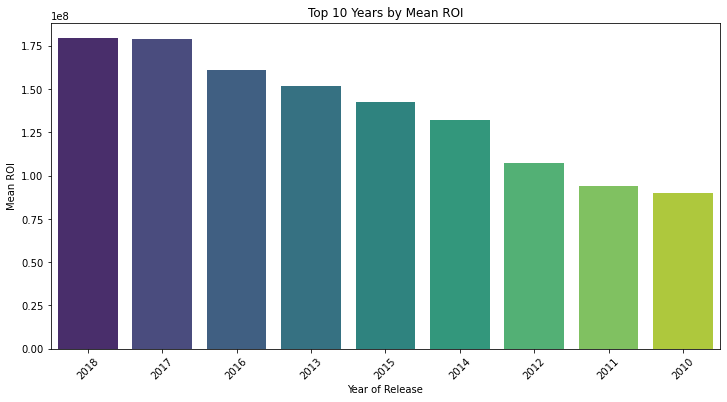

In [46]:
# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='mean', data=profit_years_mean, palette='viridis')

# Add labels and title
plt.xlabel('Year of Release')
plt.ylabel('Mean ROI')
plt.title('Top 10 Years by Mean ROI')
plt.xticks(rotation=45)
plt.show()

### Director Most Likely to Create a Film with a High Return on Investment

Based on data, the top directors likely to provide high Return on Investment are:

``Steven Spielberg``

``Ridley Scott``

``Clint Eastwood``

In [47]:
# Group data by director and calculate count, mean, and median of ROI
profit_directors_avg = movie_data.groupby('director_name')['roi'].agg(['count', 'mean', 'median'])

In [48]:
# Sort by the number of films directed and display top 5 directors
top_directors = profit_directors_avg.sort_values(by='count', ascending=False).head(3)
top_directors

,count,mean,median
director_name,,,
Steven Spielberg,7,2.769286e+08,183400000.0
Ridley Scott,7,2.846143e+08,268200000.0
Clint Eastwood,6,1.838333e+08,95050000.0


In [49]:
# Reset the index to have 'director_name' as a column
top_directors = top_directors.reset_index()

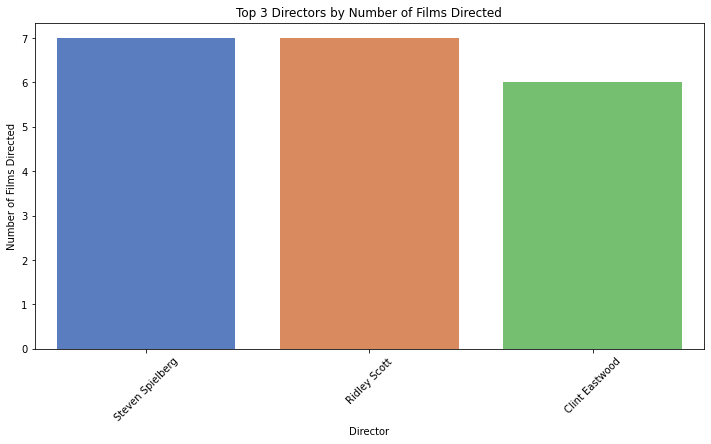

In [50]:
# Plot the number of films directed by top directors
plt.figure(figsize=(12, 6))
sns.barplot(x='director_name', y='count', data=top_directors, palette='muted')
plt.xlabel('Director')
plt.ylabel('Number of Films Directed')
plt.title('Top 3 Directors by Number of Films Directed')
plt.xticks(rotation=45)
plt.show()

### Return on Investment Based on Genre

Films with the combination of genres such as Action, Adventure, and Sci-Fi are most likely to provide a high Return on Investment.

In [51]:
# Group data by genres and calculate count, mean, and median of Return on Investment
profit_genre_avg = movie_data.groupby('genres')['roi'].agg(['count','mean', 'median'])


In [52]:
# Sort by mean Return on Investment and display top 10 genres
top_genres_mean = profit_genre_avg.sort_values(by='mean', ascending=False).head(10)
top_genres_mean

,count,mean,median
genres,,,
"Adventure,Drama,Sport",1,1.276400e+09,1.276400e+09
"Adventure,Fantasy",3,7.040333e+08,9.560000e+08
"Adventure,Drama,Sci-Fi",2,6.537500e+08,6.537500e+08
"Action,Adventure,Sci-Fi",42,6.179858e+08,6.289005e+08
"Comedy,Mystery",1,5.868000e+08,5.868000e+08
"Action,Comedy,Mystery",1,5.441000e+08,5.441000e+08
"Action,Adventure,Thriller",13,4.566846e+08,3.048000e+08
"Action,Adventure,Fantasy",29,4.535478e+08,3.364000e+08
"Biography,Drama,Musical",1,4.350000e+08,4.350000e+08


In [53]:
# Reset the index to have 'genres' as a column
top_genres_mean = top_genres_mean.reset_index()

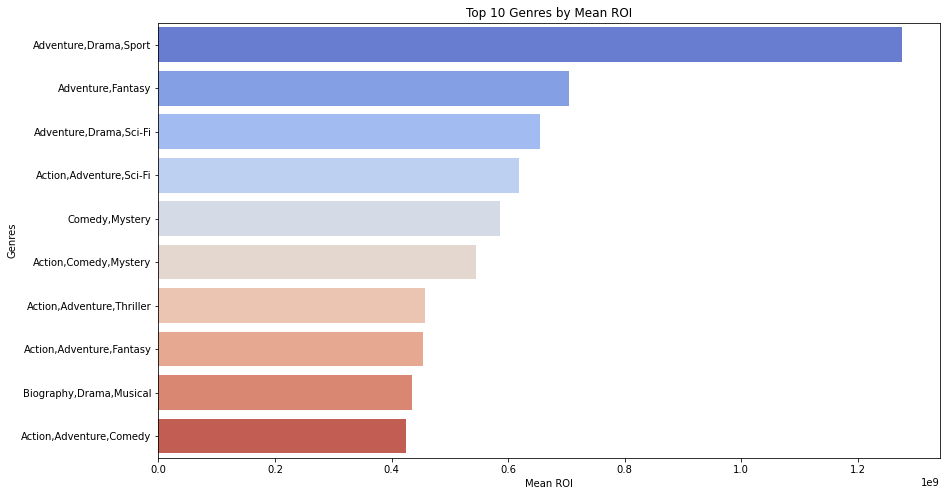

In [54]:
# Plot the bar chart
plt.figure(figsize=(14, 8))
sns.barplot(x='mean', y='genres', data=top_genres_mean, palette='coolwarm')

# Add labels and title
plt.xlabel('Mean ROI')
plt.ylabel('Genres')
plt.title('Top 10 Genres by Mean ROI')
plt.show()

### Conclusions and Recommendations

`1`Release Timing: Aim for film releases in ``2017``, ``2018``, ``2016`` offer. 

`2`Director Selection: Focus on directors like Steven ``Spielberg``, ``Ridley Scott``, and ``Clint Eastwood``.

`3`Genre Selection: Prioritize films with genres such as ``Action, Comedy, Mystery`` for the best Return on Investment.